In [1]:
import sys,mujoco,time,os,json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\helper")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\mujoco_usage")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\gpt_usage")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\detection_module")

from mujoco_parser import *
from utility import *
from transformation import *

#sys.path.append('../package/helper/')
#sys.path.append('../package/mujoco_usage/')
#sys.path.append('../package/gpt_usage/')
#sys.path.append('../package/detection_module/')
from mujoco_parser import *
from utility import *
from transformation import *
from gpt_helper import *
from owlv2 import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

c:\Users\ptfc0\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ready.


In [10]:
# Load environment
xml_path = r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\franka_panda_w_objs.xml"
env = MuJoCoParserClass(name='panda', rel_xml_path=xml_path, verbose=True)
print("Environment loaded.")

# Get current state (or initialize)
env_state = {
    'qpos': env.data.qpos.copy(),
    'qvel': env.data.qvel.copy()
}

env.reset()
env.set_state(**env_state)
env.init_viewer(azimuth=89.608063, distance=3, elevation=-11, lookat=[0, 0, 2],
                transparent=True, maxgeom=100000)

# Initial control inputs and control indices
q_init = np.zeros(env.n_ctrl)  # zero torque/control initially
idxs_step = list(range(env.n_ctrl))  # control all joints

# Dummy detection data for now
detection_result = {
    'n': 0,
    'object_names': [],
    'labels': []
}
xyz_bboxes = []
xyz_objects = []
xyz_centers = []

# Main simulation loop
while env.is_viewer_alive():
    # Step simulation with control input
    env.step(ctrl=q_init, ctrl_idxs=idxs_step)
    
    # Render
    if env.loop_every(tick_every=10):
        for idx in range(detection_result['n']):
            env.plot_spheres(ps=xyz_bboxes[idx], r=0.002, rgba=(1, 0, 0, 0.5))
            env.plot_spheres(ps=xyz_objects[idx], r=0.0025, rgba=(0, 0, 1, 0.5))
            env.plot_T(p=xyz_centers[idx], R=np.eye(3), plot_axis=True, axis_len=0.15, axis_width=0.005)
            
            object_name = detection_result['object_names'][detection_result['labels'][idx]]
            env.plot_text(p=xyz_centers[idx] + np.array([0, 0, 0.15]), label='%s' % (object_name))
            
            print(f"Object {idx} ('{object_name}') center: {xyz_centers[idx]}")
            
        env.render()
    
    if env.loop_every(tick_every=5000):
        render_img = env.grab_image(rsz_rate=1)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6, 4))
        plt.imshow(render_img)
        plt.title(f"Time: {env.get_sim_time():.2f} sec", fontsize=10)
        plt.axis('off')
        plt.show()

env.close_viewer()
print("Done.")


ValueError: Error: engine error: Python exception raised

In [3]:
import mujoco as mj
from mujoco.glfw import glfw
import OpenGL.GL as gl
from PIL import Image
import numpy as np
import os
import sim_utils
import Functions as F

# =========== Your XML and sim settings ===========
xml_path = r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\franka_panda_w_objs.xml"

simend = 300

# For callback functions (if any)
button_left = False
button_middle = False
button_right = False
lastx = 0
lasty = 0

# --------- Controller function (your IK controller) -----------
def controller(model, data):
    nv = model.nv
    ee_pos = data.site_xpos[ee_site_id].copy()        # shape (3,)
    R_ee = data.site_xmat[ee_site_id].reshape(3, 3)  # 3x3 rotation

    box_pos = data.xpos[target_body_id].copy()
    target_pos = box_pos + np.array([0.0, 0.0, 0.10])  # 10 cm above box
    R_box = data.xmat[target_body_id].reshape(3, 3)

    R_box_rot = R_box @ F.RotX(np.pi/2) @ F.RotY(-1*np.pi /2)

    pos_err = target_pos - ee_pos

    R_err = 0.5 * (np.cross(R_ee[:,0], R_box_rot[:,0]) +
                   np.cross(R_ee[:,1], R_box_rot[:,1]) +
                   np.cross(R_ee[:,2], R_box_rot[:,2]))

    error = np.hstack((pos_err, R_err))  # 6x1

    Jp = np.zeros((3, nv))
    Jr = np.zeros((3, nv))
    mj.mj_jacSite(model, data, Jp, Jr, ee_site_id)
    J_full = np.vstack((Jp, Jr))  # 6 x nv

    lam0 = 1e-3
    lam_scale = 1e-2
    lam = lam0 + lam_scale * np.linalg.norm(pos_err)
    A = J_full @ J_full.T + lam * np.eye(6)
    try:
        dq = J_full.T @ np.linalg.solve(A, error)
    except np.linalg.LinAlgError:
        dq = J_full.T @ np.linalg.pinv(A) @ error

    max_dq_norm = 0.2
    dq_norm = np.linalg.norm(dq)
    if dq_norm > max_dq_norm:
        dq *= max_dq_norm / dq_norm
    alpha = 0.25
    dq_step = alpha * dq

    q = data.qpos[:nv].copy()
    q_des = q + dq_step

    Kp = 200
    Kd = 10.0
    q_err = q_des - q
    qd = data.qvel[:nv].copy()
    f = data.qfrc_bias.copy()
    tau = (Kp * q_err) + (Kd * (-qd)) + f

    torque_limit = 200.0
    tau = np.clip(tau, -torque_limit, torque_limit)
    data.qfrc_applied[:] = tau

# --------- Grab RGB image from OpenGL framebuffer ----------
def grab_mujoco_rgb_image(viewport_width, viewport_height):
    gl.glPixelStorei(gl.GL_PACK_ALIGNMENT, 1)
    pixels = gl.glReadPixels(0, 0, viewport_width, viewport_height, gl.GL_RGBA, gl.GL_UNSIGNED_BYTE)
    image = np.frombuffer(pixels, dtype=np.uint8).reshape(viewport_height, viewport_width, 4)
    image = np.flip(image, axis=0)  # Flip vertically
    return Image.fromarray(image)

# --------- Depth to xyz point cloud in camera frame -----------
def depth_to_xyz(depth_img, cam, viewport_width, viewport_height):
    # Convert depth buffer to z-buffer range [0,1]
    depth = depth_img.astype(np.float32) / (2**24 - 1)
    # MuJoCo depth is nonlinear, convert to linear depth using near/far planes
    near = 0.01
    far = 1000.0
    z_linear = near * far / (far - (far - near) * depth)

    # Compute focal length in pixels
    fovy_rad = np.deg2rad(45)  # You can adjust if you want to use cam params differently
    fy = viewport_height / (2 * np.tan(fovy_rad / 2))
    fx = fy  # assume square pixels
    cx = viewport_width / 2
    cy = viewport_height / 2

    # Create meshgrid of pixel coordinates
    x = np.arange(viewport_width)
    y = np.arange(viewport_height)
    xv, yv = np.meshgrid(x, y)

    # Compute xyz in camera coordinates
    X = (xv - cx) * z_linear / fx
    Y = (yv - cy) * z_linear / fy
    Z = z_linear

    xyz = np.stack([X, Y, Z], axis=-1)  # shape (H,W,3)
    return xyz

# --------- Convert spherical camera params to position and rotation ----------
def cam_spherical_to_pose(cam):
    az = np.deg2rad(cam.azimuth)
    el = np.deg2rad(cam.elevation)
    dist = cam.distance
    lookat = cam.lookat

    x = dist * np.cos(el) * np.sin(az)
    y = dist * np.cos(el) * np.cos(az)
    z = dist * np.sin(el)
    cam_pos = lookat + np.array([x, y, z])

    z_axis = lookat - cam_pos
    z_axis /= np.linalg.norm(z_axis)

    up = np.array([0, 0, 1])
    x_axis = np.cross(up, z_axis)
    x_axis /= np.linalg.norm(x_axis)

    y_axis = np.cross(z_axis, x_axis)

    cam_mat = np.stack([x_axis, y_axis, z_axis], axis=1)
    return cam_pos, cam_mat

# =========== Initialization ===========


model = mj.MjModel.from_xml_path(xml_path)
data = mj.MjData(model)
cam = mj.MjvCamera()
opt = mj.MjvOption()

ee_site_name = "grip_site"
target_body_name = "obj_box_06"
ee_site_id = model.site(ee_site_name).id
target_body_id = model.body(target_body_name).id

glfw.init()
window = glfw.create_window(1200, 900, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

glfw.set_key_callback(window, sim_utils.keyboard(model, data))
glfw.set_mouse_button_callback(window, sim_utils.mouse_button())
glfw.set_cursor_pos_callback(window, sim_utils.mouse_move(model, scene, cam))
glfw.set_scroll_callback(window, sim_utils.scroll(model, scene, cam))

# Your exact camera config
cam.azimuth = 89.608063
cam.elevation = -11.588379
cam.distance = 3.0
cam.lookat = np.array([0.0, 0.0, 2.0])

mj.set_mjcb_control(controller)
captured = False

while not glfw.window_should_close(window):
    simstart = data.time

    while (data.time - simstart < 1.0 / 60.0):
        mj.mj_step(model, data)

    if data.time >= simend:
        break

    viewport_width, viewport_height = glfw.get_framebuffer_size(window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    mj.mjv_updateScene(model, data, opt, None, cam,
                       mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    if not captured:
        # Grab RGB image
        img = grab_mujoco_rgb_image(viewport_width, viewport_height)
        img.save("camera_capture.png")
        print("Saved camera_capture.png")
        ego_rgb_img=np.array(img)

        # Read depth buffer
        depth_buffer = gl.glReadPixels(0, 0, viewport_width, viewport_height,
                                       gl.GL_DEPTH_COMPONENT, gl.GL_FLOAT)
        depth_img = np.frombuffer(depth_buffer, dtype=np.float32).reshape(viewport_height, viewport_width)
        depth_img = np.flip(depth_img, axis=0)  # flip vertically

        # Convert depth to xyz in camera frame
        xyz_img = depth_to_xyz(depth_img, cam, viewport_width, viewport_height)

        # Get camera pose from spherical params
        cam_pos, cam_mat = cam_spherical_to_pose(cam)

        # Transform points from camera frame to world frame
        xyz_flat = xyz_img.reshape(-1, 3).T  # shape (3, N)
        xyz_world_flat = cam_mat @ xyz_flat + cam_pos.reshape(3,1)
        xyz_img_world = xyz_world_flat.T.reshape(viewport_height, viewport_width, 3)

        # Optional: save or process xyz_img_world as needed
        print("Captured xyz point cloud in world coordinates.")

        captured = True

    glfw.swap_buffers(window)
    glfw.poll_events()

glfw.terminate()

Saved camera_capture.png
Captured xyz point cloud in world coordinates.


In [4]:
png_path = r'C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\camera_capture.png'
img = Image.open(png_path)   # PIL Image object
img.show()

In [5]:
# Instantiate GPT4V helper
GPT = GPT4VchatClass(
    gpt_model = "gpt-4o", #"gpt-4-vision-preview",
    role_msg  = "You are a helpful agent with vision capabilities; do not respond to objects not depicted in images.",
    key_path  = r"C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt",
)
print ("Ready.")

key_path:[C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-anot
her-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

Ready.


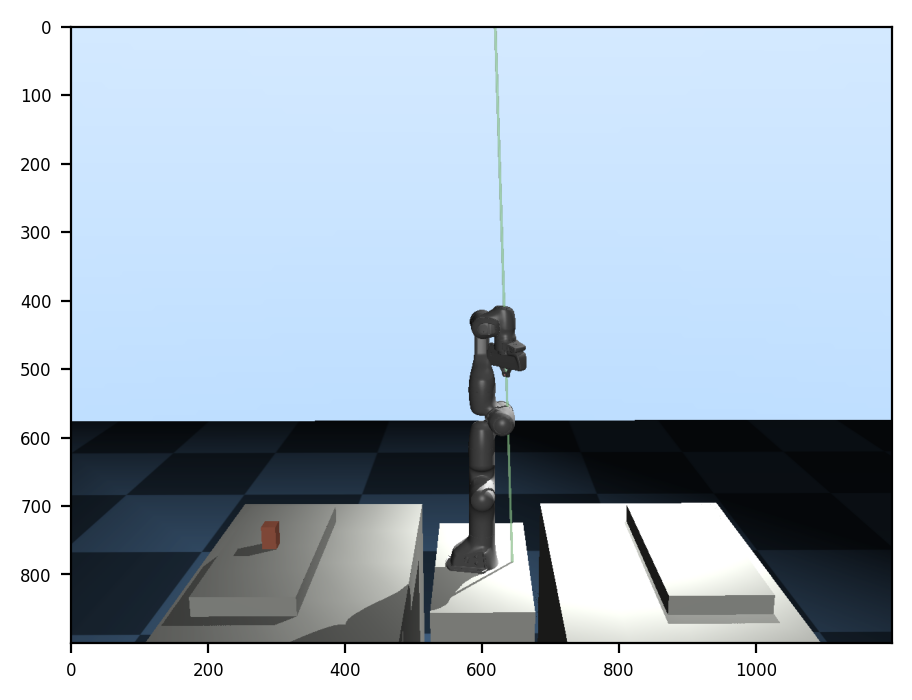

[USER_MSG]

<img1>Describe the image.

[GPT_OUTPUT]

The image shows a humanoid robot standing upright on a platform. The robot appears to be balancing on one foot on the middle platform. To the left, there is another platform with a small red object and a flat surface. To the right, there is a third platform which is flat and empty. The background has a checkered pattern on the floor with a gradient blue wall. A green vertical line extends upward from the robot, possibly indicating balance or motion tracking.

[USER_MSG]


        Could you list down the object names suitable for detection in a json format? specifically what the robot could pick up the object is smaller than the robot hand 
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        

[GPT_OUTPUT]

Certainly! Based on the image, here's a JSON format listing the suitable object for detection:

```json
{
  "objects": [
    "small red object"
  ]
}
```

Done.


In [6]:
# Plot
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.show()
# Describe the image
GPT.chat(
    user_msg = "<img1>Describe the image.",
    images   = [png_path],
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = False,
    MAX_TOKENS       = 512,
)
# List down the objects in the scene
ret = GPT.chat(
    user_msg = """
        Could you list down the object names suitable for detection in a json format? specifically what the robot could pick up the object is smaller than the robot hand 
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)
print ("Done.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


object_names:['small red object']


c:\Users\ptfc0\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\models\owlv2\processing_owlv2.py:201: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


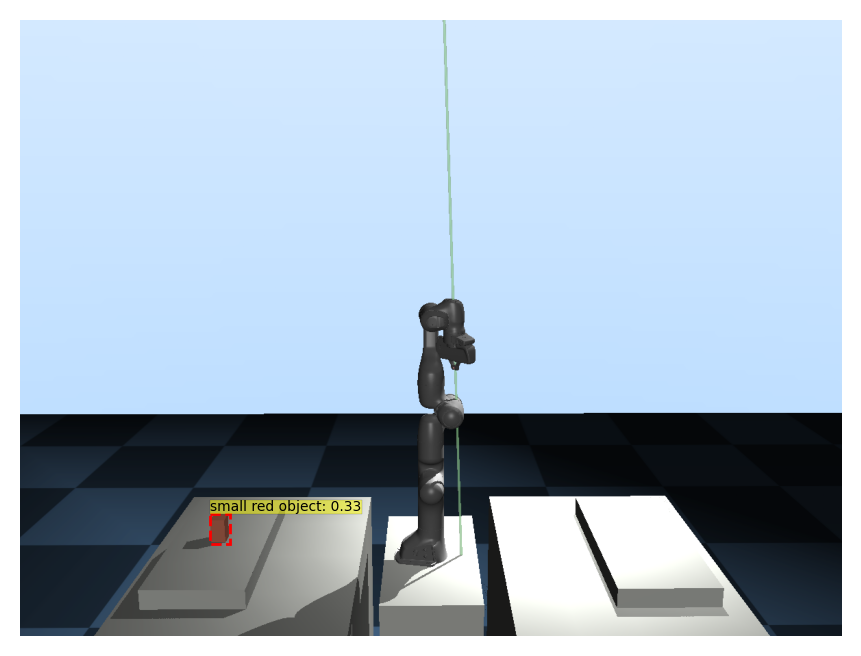

In [7]:
# Parse object names
json_string = ret[ret.find('{'):ret.rfind('}')+1]
data = json.loads(json_string)
object_names = data['objects']
print ("object_names:%s"%(object_names))

# Open-vocab detection
owlvit = Owlv2()
detection_result = owlvit.detect_objects(
    image_path    = png_path,
    object_names  = object_names,
    box_threshold = 0.25,
)

# Plot detection results
plot_detection_result(
    image_path       = png_path,
    detection_result = detection_result,
    figsize          = (6,4),
    fontsize         = 5,
)

In [8]:
# Get pcd xyzs of objects
xyz_bboxes = []
for box in detection_result['boxes']:  # for each detection box
    # Scale bounding box coords from ego_rgb_img to xyz_img_world size
    x1, y1, x2, y2 = (box * xyz_img_world.shape[0] / ego_rgb_img.shape[0]).int()
    
    # Extract xyz points inside bbox from xyz_img_world
    xyz = xyz_img_world[y1:y2+1, x1:x2+1, :].reshape((-1, 3))  # [M x 3]
    xyz_bboxes.append(xyz)  # append point cloud xyz of bbox

# Exclude overlapping point clouds
xyz_bboxes_unique = exclude_overlapping_pcd_within_list(xyz_bboxes)

# Get point cloud xyz of objects and their centers
xyz_objects, xyz_centers = [], []
for xyz in xyz_bboxes_unique:
    # Discretize z to detect floor robustly
    z_discretized = np.round(xyz[:, 2] / 0.01) * 0.01  # discretized height [m]
    unique, counts = np.unique(z_discretized, return_counts=True)
    k = int(len(unique) * 0.5)  # robust floor detection threshold
    top_k_indices = np.argsort(counts)[-k:]
    top_k_unique_values = unique[top_k_indices]
    z_floor = np.min(top_k_unique_values) + 0.005  # floor height + margin
    
    # Filter points above floor level
    xyz_object = xyz[xyz[:, 2] >= z_floor]
    xyz_objects.append(xyz_object)
    
    # Fit circle on XY plane to find center
    xy_object = xyz_object[:, :2]  # [M x 2]
    xy_center, radius = fit_xy_circle(xy_object)  # center: [2]
    
    # Append xyz center with floor z
    xyz_centers.append(np.append(xy_center, z_floor))  # [3]

print("Done.")


Done.


Object 0 ('small red object') center: [0.   0.   1.41]


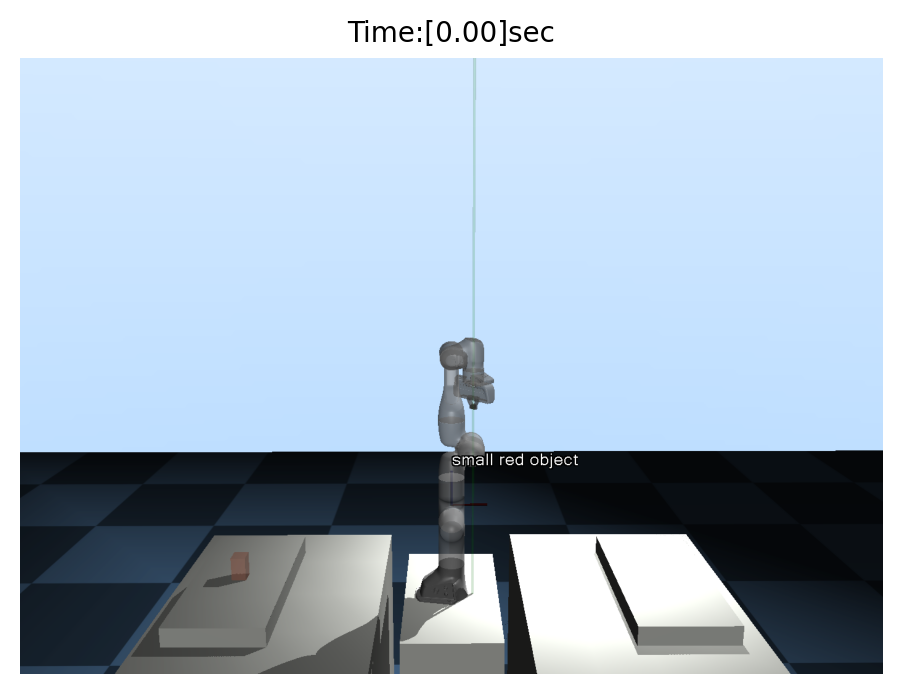

Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 ('small red object') center: [0.   0.   1.41]
Object 0 (

In [9]:
env.reset()
env.set_state(**env_state)
env.init_viewer(azimuth=89.6, distance=3, elevation=-11.588379, lookat=[0, 0, 2],
                transparent=True, maxgeom=100000)

while env.is_viewer_alive():
    # Step
    env.step(ctrl=q_init, ctrl_idxs=idxs_step)
    
    # Render
    if env.loop_every(tick_every=10):
        for idx in range(detection_result['n']):
            env.plot_spheres(ps=xyz_bboxes[idx], r=0.002, rgba=(1, 0, 0, 0.5))
            env.plot_spheres(ps=xyz_objects[idx], r=0.0025, rgba=(0, 0, 1, 0.5))
            env.plot_T(p=xyz_centers[idx], R=np.eye(3), plot_axis=True, axis_len=0.15, axis_width=0.005)
            
            object_name = detection_result['object_names'][detection_result['labels'][idx]]
            env.plot_text(p=xyz_centers[idx] + np.array([0, 0, 0.15]), label='%s' % (object_name))
            
            # Print the point center here
            print(f"Object {idx} ('{object_name}') center: {xyz_centers[idx]}")
            
        env.render()
    
    # Plot every 10 seconds
    if env.loop_every(tick_every=5000):
        # Grab current view
        render_img = env.grab_image(rsz_rate=1)
        
        # Plot image
        plt.figure(figsize=(6, 4))
        plt.imshow(render_img)
        plt.title("Time:[%.2f]sec" % (env.get_sim_time()), fontsize=10)
        plt.axis('off')
        plt.show()

env.close_viewer()
print("Done.")


In [ ]:
# Store current GPT message
gpt_state = GPT.get_state()
print ("GPT state ready.")

In [ ]:
# Set GPT state
GPT.set_state(state=gpt_state)
ret = GPT.chat(
    user_msg = """
        xyz_centers in the code holds the point centers for each detected object can u tell me what those are?
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)